In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import pandas_datareader as pdr
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\12094\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
#dataset=pd.read_csv('C:/Users/12094/DataSciencePractice/repos/stock_trading/AlgorithmicTrading-MachineLearning/RELIANCE.NS.csv', index_col=0)

In [3]:
#dataset.head()

 ## Reading Stock Data Information of Western Digital (symbol: WDC) from Yahoo Website

In [4]:
start = pd.to_datetime('1998-01-01')
end = pd.datetime.today()
df_wdc = web.DataReader('WDC', 'yahoo', start, end)
df_wdc.drop(['Adj Close','Volume'], axis=1,inplace=True)

(array([728659., 730120., 731581., 733042., 734503., 735964., 737425.]),
 <a list of 7 Text xticklabel objects>)

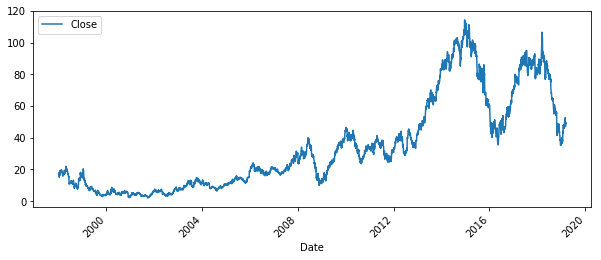

In [5]:
fig,ax=plt.subplots()
df_wdc["Close"].plot(legend=True,figsize=(10,4))
plt.xticks(rotation=45)

In [6]:
df_wdc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5332 entries, 1998-01-02 to 2019-03-13
Data columns (total 4 columns):
High     5332 non-null float64
Low      5332 non-null float64
Open     5332 non-null float64
Close    5332 non-null float64
dtypes: float64(4)
memory usage: 208.3 KB


No null values, so no task need for removing missing vaues

In [7]:
#df_stock=dataset.copy()
df_stock=df_wdc

Before we split the data set we have to standardize the dataset. This process makes the mean of
all the input features equal to zero and also converts their variance to 1. we will scale both
the inputs and targets\ using sklearn’s MinMaxScale

In [8]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler=sklearn.preprocessing.MinMaxScaler()
    df['Open']=min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High']=min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low']=min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close']=min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    return(df,min_max_scaler)

In [9]:
df_stock_norm,scaler=normalize_data(df_stock.copy())

# Defince the train, validation and test percentage

In [10]:
valid_set_size_percentage=.10
test_set_size_percentage=.10
## sequence Length
seq_len=19

We split the whole dataset into train, valid and test data. Then we can build X & y. So we will get x_train,
y_train, x_valid, y_valid, x_test & y_test. This is a crucial part.The function takes two arguments: a dataset,
and sequence length, which is the number of previous time steps to use as input variables to predict next output

In [11]:
def data_preparation (data_df,seq_len):
    data_raw=data_df.values
    data=[]
    for index in range (len(data_raw)-(seq_len+1)):
        data.append(data_raw[index:index+seq_len+1])
    data=np.array(data)
    valid_set_size= int(np.round(valid_set_size_percentage*data.shape[0]))
    test_set_size=int(np.round(test_set_size_percentage*data.shape[0]))
    train_set_size=data.shape[0]-valid_set_size-test_set_size
    X_train=data[:train_set_size,:-1,:]
    y_train=data[:train_set_size,-1,:]
    X_valid=data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid=data[train_set_size:train_set_size+valid_set_size,-1,:]
    X_test=data[train_set_size+valid_set_size:,:-1,:]
    y_test=data[train_set_size+valid_set_size:,-1,:]
    return[X_train,y_train,X_valid,y_valid,X_test,y_test]


In [12]:
X_train,y_train,X_valid,y_valid,X_test,y_test =data_preparation(df_stock_norm,seq_len)

In [13]:
X_train_orig=X_train.copy() 
y_train_orig=y_train.copy()

In [14]:
def randomize(X_train, y_train):
    permutation = np.random.permutation(X_train.shape[0])
    shuffled_X_train = X_train[permutation, :, :]
    shuffled_y_train = y_train[permutation]
    return shuffled_X_train, shuffled_y_train

In [15]:
def batch_genrator (X_train, y_train, batch_size, sequence_length, num_x_signals,num_y_signals):
 idx=-1
 iterationPerEpoch=int(X_train.shape[0]/batch_size)
 while(True):
    # Allocate a new array for the batch of input signals
    X_shape=(batch_size,sequence_length,num_x_signals)
    X_batch=np.zeros(shape=X_shape, dtype=np.float16)
    # Allocate a new array for the batch of output signals
    y_shape=(batch_size, sequence_length, num_y_signals)
    y_batch=np.zeros(shape=y_shape, dtype=np.float16)
    # Get a random start-index.
    # This points somewhere into the training-data
    #idx=np.random.randint(x_train.shape[0]-sequence_length)
    # Copy the sequences of data starting at this index.
    if idx ==iterationPerEpoch:
        idx=0
    else:
        idx=idx+1
    X_batch=X_train[idx:idx+batch_size]
    y_batch=y_train[idx:idx+batch_size]
    yield (X_batch,y_batch)

## Parameters 

In [16]:
n_steps=seq_len
n_inputs=X_train.shape[2]
n_neurons=200
n_outputs=y_train.shape[1]
n_layers=2
learning_rate=0.001
batch_size=50
n_epochs=100
num_x_signals=X_train.shape[2]
num_y_signals=y_train.shape[-1]
train_set_size=X_train.shape[0]
test_set_size=X_test.shape[0]

## LSTM With PEEPHOLES Model Building

In [17]:
tf.reset_default_graph()
X=tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y=tf.placeholder(tf.float32,[None,n_outputs])
layers=[tf.contrib.rnn.LSTMCell(num_units=n_neurons,activation=tf.nn.relu,use_peepholes=True) for layer in range (n_layers)]
multi_layer_cell=tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs,states=tf.nn.dynamic_rnn(multi_layer_cell,X,dtype=tf.float32)
stacked_rnn_outputs=tf.reshape(rnn_outputs,[-1,n_neurons])
stacked_outputs=tf.layers.dense(stacked_rnn_outputs,n_outputs)
outputs=tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])
outputs=outputs[:,n_steps-1,:]

## Cost Function

In [18]:
loss=tf.reduce_mean(tf.square(outputs-y))

## Optimizer

In [19]:
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

## Fitting the model And Prediction

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X_train, y_train=randomize(X_train, y_train)
    for iteraration in range (int(n_epochs*train_set_size/batch_size)):
        X_batch, y_batch=next(batch_genrator(X_train, y_train, batch_size, seq_len, num_x_signals,num_y_signals))
        #x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op,feed_dict={X:X_batch, y:y_batch})
        if iteraration% int(5*train_set_size/batch_size)==0:
            mes_train=loss.eval(feed_dict={X:X_train,y:y_train})
            mes_valid=loss.eval(feed_dict={X:X_valid,y:y_valid})
            print("%.2f epochs: MSE train/valid=%.6f/%.6f"%(iteraration*batch_size/train_set_size, mes_train,mes_valid))
    y_train_pred=sess.run(outputs,feed_dict={X:X_train_orig})
    y_valid_pred=sess.run(outputs,feed_dict={X:X_valid})
    y_test_pred=sess.run(outputs,feed_dict={X:X_test})

0.00 epochs: MSE train/valid=0.074080/0.356790
5.00 epochs: MSE train/valid=0.000191/0.001719
10.00 epochs: MSE train/valid=0.000177/0.001972
15.00 epochs: MSE train/valid=0.000186/0.001883
20.00 epochs: MSE train/valid=0.000160/0.001673
25.00 epochs: MSE train/valid=0.000159/0.001661
30.00 epochs: MSE train/valid=0.000160/0.001654
35.00 epochs: MSE train/valid=0.000155/0.001391
40.00 epochs: MSE train/valid=0.000142/0.001250
45.00 epochs: MSE train/valid=0.000134/0.001077
50.00 epochs: MSE train/valid=0.000125/0.000899
55.00 epochs: MSE train/valid=0.000112/0.000728
60.00 epochs: MSE train/valid=0.000132/0.000787
65.00 epochs: MSE train/valid=0.000134/0.000836
70.00 epochs: MSE train/valid=0.000146/0.000863
75.00 epochs: MSE train/valid=0.000171/0.000898
80.00 epochs: MSE train/valid=0.000185/0.000740
85.00 epochs: MSE train/valid=0.000195/0.000611
90.00 epochs: MSE train/valid=0.000194/0.000684
95.00 epochs: MSE train/valid=0.000170/0.000794


## Plotting the Graph

In [21]:
# invert predictions
trainPredict=scaler.inverse_transform(y_train_pred)
validPredict=scaler.inverse_transform(y_valid_pred)
testPredict = scaler.inverse_transform(y_test_pred)

In [23]:
df_wdc_close=df_stock['Close']

In [24]:
trainPredictPlot = np.empty_like(df_wdc_close)
trainPredictPlot=trainPredictPlot.reshape(-1,1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[seq_len+1:seq_len+1+len(trainPredict), :] = trainPredict[:,3].reshape(-1,1)

In [25]:
validPredictPlot = np.empty_like(df_wdc_close)
validPredictPlot=validPredictPlot.reshape(-1,1)
validPredictPlot[:,:]=np.nan
validPredictPlot[seq_len+1+len(trainPredict):seq_len+1+len(trainPredict)+len(validPredict), :] = validPredict[:,3].reshape(-1,1)

In [26]:
testPredictPlot = np.empty_like(df_wdc_close)
testPredictPlot=testPredictPlot.reshape(-1,1)
testPredictPlot[:,:]=np.nan
testPredictPlot[seq_len+1+len(trainPredict)+len(validPredict):, :] = testPredict[:,3].reshape(-1,1)

In [27]:
df_stock["TrainPredicted"]=trainPredictPlot
df_stock["ValidPredicted"]=validPredictPlot
df_stock["TestPredicted"]=testPredictPlot

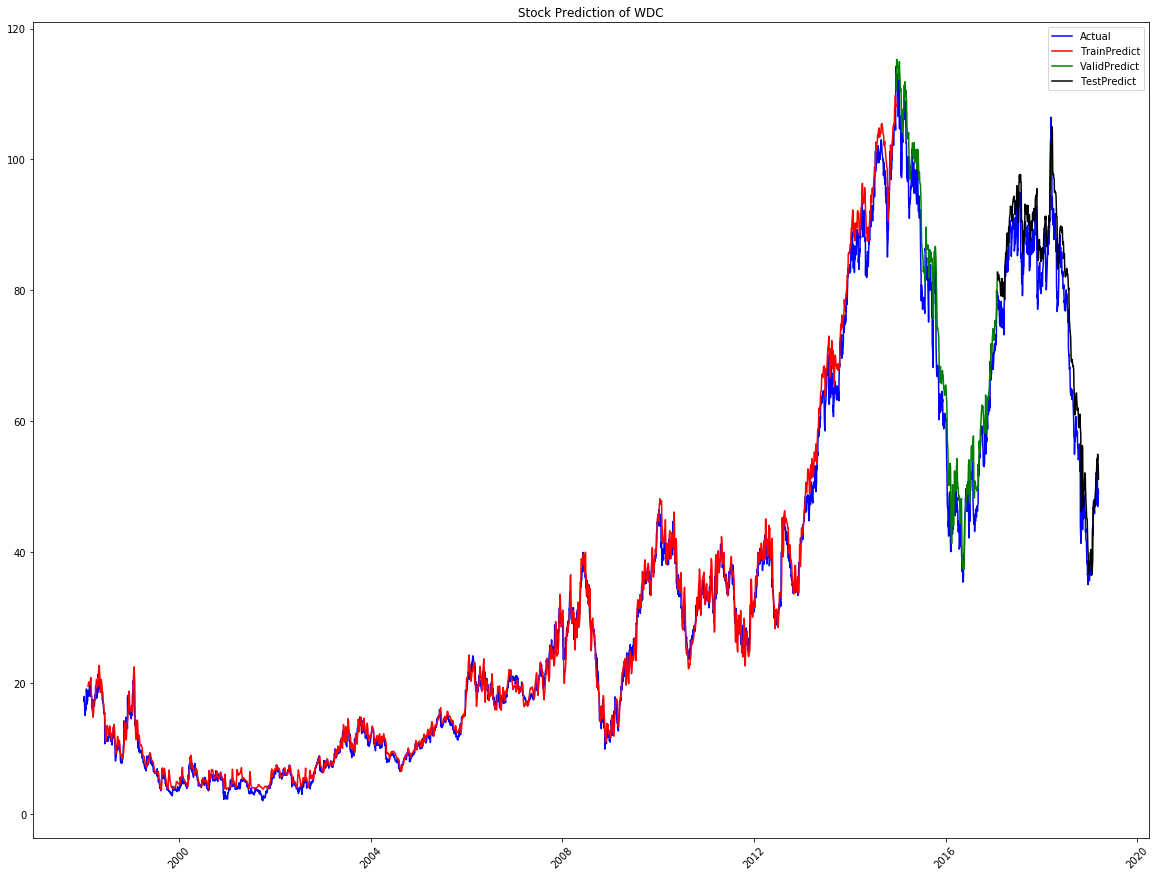

In [28]:
#fig,ax=plt.subplots()
plt.figure(figsize=(20,15))
plt.plot(df_stock["Close"],color='blue',label='Actual')
plt.plot(df_stock["TrainPredicted"],color='red',label='TrainPredict')
plt.plot(df_stock["ValidPredicted"],color='green',label='ValidPredict')
plt.plot(df_stock["TestPredicted"],color='black',label='TestPredict')
plt.title("Stock Prediction of WDC")
plt.xticks(rotation=45)
plt.legend(loc='best')